## 対応の無い2標本のt検定の事例

異なる母集団から無作為抽出された2つの標本にてついて、標本平均が等しいかどうか？を検定する。

### (0)事前準備

In [1]:
# ライブラリ
import os
import sys
sys.path.append("../../scripts")
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
np.random.seed(111)
import random
random.seed(111)

# scipy
from scipy import stats
# graph
import matplotlib.pyplot as plt
import seaborn as sns

# scripts
import utils as u
# graph setting
u.graph_setting()

### (0) テーマのためのデータセット

In [2]:
# scikit-learnに用意されている、糖尿病患者のデータセットを使う
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

# diabetesのデータセットは、辞書型で格納されているので、扱いやすいようにpandasのデータフレームに変換する。
# 各特徴データ
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
# ラベル, 種類のデータ。各数値ラベルを名前に置き換えて加える。
df["target"] = diabetes.target

df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [21]:
# データセットの準備
# 標準化されている'age'のパラメータで、0以上と0未満で標本を分け、150サンプルと200サンプルずつ標本抽出する。
df_1 = df[df["age"]>=0].sample(150, random_state=111).reset_index(drop=True)
df_2 = df[df["age"]<0].sample(200, random_state=111).reset_index(drop=True)

# dataset 1, and 2, 1年後の糖尿病の進行度を示す値の目的変数を値とする。データサイズを最大の方に合わせる
values1 = df_1["bmi"].values
values2 = df_2["bmi"].values

print(f"Sample count -> Sample1 : Sample2 = {len(values1)} / {len(values2)}")
values1, values2

Sample count -> Sample1 : Sample2 = 150 / 200


(array([-0.03638469, -0.00836158, -0.04069594, -0.03854032,  0.08864151,
        -0.02129532, -0.03854032, -0.00405033, -0.06332999, -0.02452876,
        -0.02129532,  0.07139652,  0.02720622,  0.01211685,  0.09295276,
        -0.02991782, -0.00836158,  0.05954058,  0.11127556,  0.01966154,
        -0.02237314, -0.00405033, -0.03638469,  0.01750591,  0.02612841,
         0.05954058, -0.04392938, -0.02560657, -0.03530688,  0.03367309,
        -0.00620595, -0.01698407, -0.046085  , -0.00728377, -0.00620595,
         0.05954058,  0.00457217, -0.00512814,  0.03582872,  0.02073935,
        -0.03099563, -0.01267283,  0.04552903, -0.00728377,  0.01211685,
         0.02181716, -0.02021751, -0.02129532, -0.02884001, -0.03207344,
        -0.00189471,  0.07678558, -0.04500719,  0.05846277,  0.02289497,
         0.12313149, -0.06440781,  0.0250506 ,  0.0347509 , -0.02021751,
        -0.03961813, -0.00297252,  0.06169621,  0.03906215,  0.01427248,
        -0.046085  , -0.03207344,  0.00672779, -0.0

### (0) データを確認

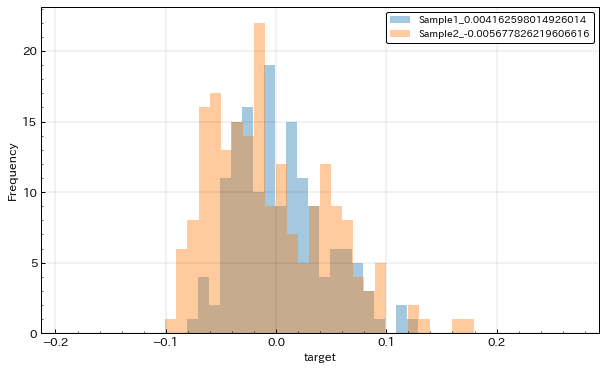

In [22]:
# ヒストグラム
fig, ax = plt.subplots(figsize=(10,6))

sns.distplot(values1, bins=np.arange(np.min(values1)-0.1, np.max(values1)+0.1, 0.01), kde=False, ax=ax, label=f"Sample1_{np.mean(values1)}")
sns.distplot(values2, bins=np.arange(np.min(values2)-0.1, np.max(values2)+0.1, 0.01), kde=False, ax=ax, label=f"Sample2_{np.mean(values2)}")
ax.set_xlabel("target")
ax.set_ylabel('Frequency')
ax.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


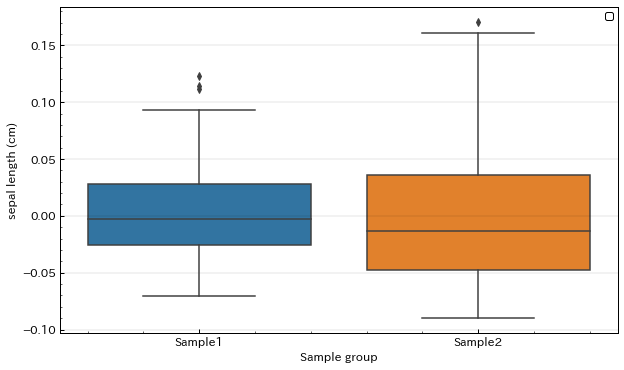

In [23]:
# ボックスプロット
fig, ax = plt.subplots(figsize=(10,6))

data = pd.concat([
       pd.DataFrame({"Sample":["Sample1" for i in range(len(values1))],
                     "Values":values1}),
       pd.DataFrame({"Sample":["Sample2" for i in range(len(values2))],
                     "Values":values2})
       ]).reset_index(drop=True)

sns.boxplot(data=data, x="Sample", y="Values")
ax.set_xlabel("Sample group")
ax.set_ylabel("sepal length (cm)")
ax.legend()

### (0) 想定する分析シーン

- ある年齢を基準で2標本の糖尿病患者グループを作り、BMIを計測する。<br>
- 取得したデータは、標本1は150人、標本2は200人を抽出したものとする。<br>
- それぞれの年齢帯におけるBMI平均値に差があるといえるか？を統計的に検定する。<br>

*データセットは元のdiabetesデータを、標準化された0を基準に2グループに分けたデータから、サンプルを抽出したデータを取り扱う。<br>

### (1) 問題設定
- 帰無仮説$H_0$と対立仮説$H_1$を定義する。<br>

帰無仮説$H_0$：年齢帯によって、BMIの平均値は変わらない。<br>
対立仮説$H_1$：年齢帯によって平均値が異なる。<br>

### (2) 適切な検定方法を選択する。
- 検定の目的、データの確認結果、サンプル数から適切な検定方法を選択する。<br>

1. 検定の目的<br>
-> 2つの異なる母集団から、それぞれ無作為抽出された2つの標本グループについて、その標本平均が等しいかどうか？を検定する。

2. データの確認 (ただし本分析においては仮定を置いたものとする。)<br>
    2-1. 正規性の仮定<br>
        -> 母集団は正規分布に従っている。<br>
    2-2. 独立性の仮定<br>
        -> 母集団内の個体同士は互いに独立している。<br>
    2-3. 等分散性の仮定<br>
        ->2つの母集団の分散が等しい<br>

3. サンプル数の確認<br>
    サンプル数：$n_1$=150, $n_2$=200<br>
        ->標本群30サンプル以上であり十分なサンプル数がある。分布の平均値やばらつきが妥当性もって評価できると考えた。

### 検定方法：t検定を利用する。

### (3) 優位水準を定義する。
- 優位と判断する水準を定義する。<br>

優位水準α=5%(両側)する。<br>

### (4) 検定統計量を計算する。
- 選択した検定方法に基づいて、検定統計量を計算する。<br>

方法1) 各統計量を求めつつ計算する

t値の計算<br>

$t = \frac{\bar{X_1}-\bar{X_2}}{\sigma*\sqrt{\frac{1}{n_1}+\frac{1}{n_2}}}\\$
<br>

各変数<br>

$\bar{X_1} : X_1の平均値$<br>
$\bar{X_2} : X_2の平均値$<br>
$\sigma^2 : 母分散$<br>
$n_1 : 標本1のサンプル数$<br>
$n_2 : 標本2のサンプル数$<br>


In [16]:
# Function
def calc_tvalue(values1:list, values2:list)->float:
    '''
    tを計算する

    Args
        values1 (list) : 標本1の計算対象の1次元リスト。numpy.arrayやpandas.Seriesも可
        values2 (list) : 標本1の計算対象の1次元リスト。numpy.arrayやpandas.Seriesも可

    Return
        t : 計算されたt値を返す。
    '''

    # calc mean
    m_1, m_2 = np.mean(values1), np.mean(values2)
    # calc std, 母分散が等しいと仮定。合わせたデータで不偏標本標準偏差を使う
    s = np.std(np.concatenate([np.array(values1), np.array(values2)]), ddof=1)
    # dataset count
    n_1, n_2 = len(values1), len(values2)

    # calc standard error
    se = np.sqrt(s**2*(1/n_1 + 1/n_2))

    # t value
    t = (m_1 - m_2) / se

    # print each value
    print(f"Average value, sample1 / sample2 : {m_1}/{m_2}")
    print(f"Standard error : {se}")
    print(f"t value : {t}")

    return t

In [24]:
# calculate t value
t = calc_tvalue(values1=values1, values2=values2)

# 両側信頼係数のt値を求める。
# 自由度
d = len(values1) - 1
# 片側優位水準
alpha = 0.05

# scipy.statsを使って計算する。
t_thre = stats.t.ppf(1 - alpha/2, d)
print(f"t value threshold : {t_thre}")

Average value, sample1 / sample2 : 0.004162598014926014/-0.005677826219606616
Standard error : 0.005241526676250299
t value : 1.8773965759098847
t value threshold : 1.976013177679155


方法2) scipy.stats.ttest_ind()関数を使って計算する。

In [28]:
t_value, p_value = stats.ttest_ind(a=values1, b=values2, alternative="two-sided", equal_var=True)

print(f"t value : {t_value}")

t value : 1.8842437808010193


### (5) p値を計算する。
- 検定統計量に基づいてp値を計算する。<br>

In [29]:
print(f"p value : {p_value}")

p value : 0.06036533523967504


### (6) 結果を解釈する。
- p値と優位水準を比較して結果を解釈する。<br>
p値≦$α$：帰無仮説を棄却し、対立仮説を採択する。<br>
p値>$α$：帰無仮説を棄却できない

### 判定
- p値は0.06と両側優位水準5%より大きい。よって帰無仮説は棄却されない。<br>
-> 差は無い

- 一方で結果的に両側優位水準10%とした場合では、帰無仮説を棄却できた。

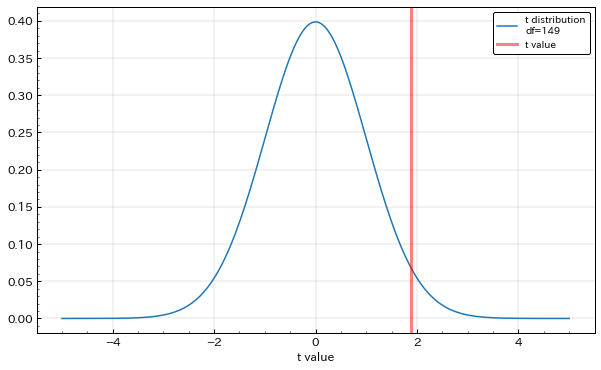

In [30]:
# t分布サンプリング
t_range = np.linspace(-5,5,200)
t_value_ar = []
for i in t_range:
    t_value_ar.append(stats.t.pdf(x=i, df=len(values1)+len(values2)-2))

# plot
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(t_range, t_value_ar, label="t distribution\ndf={}".format(len(values1)-1))
# t value
ax.axvline(x=t_value, ymin=0, ymax=1, color="red", lw=3, linestyle="-", alpha=0.5, label="t value")
ax.set_xlabel("t value")
ax.legend()

### 母分散が異なる前提でt検定をした場合。➡ウェルチのt検定

### (4) 検定統計量を計算する。
- 選択した検定方法に基づいて、検定統計量を計算する。<br>

方法1) 各統計量を求めつつ計算する

$Weltch \ t = \frac{\bar{X_1}-\bar{X_2}}{\sqrt{\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}}}\\$
<br>

各変数<br>

$\bar{X_1} : X_1の平均値$<br>
$\bar{X_2} : X_2の平均値$<br>
$s_1^2 : X_1の標本分散$<br>
$s_2^2 : X_2の標本分散$<br>
$n_1 : 標本1のサンプル数$<br>
$n_2 : 標本2のサンプル数$<br>

In [31]:
# Function
def calc_tvalue_weltch(values1:list, values2:list)->float:
    '''
    tを計算する

    Args
        values1 (list) : 標本1の計算対象の1次元リスト。numpy.arrayやpandas.Seriesも可
        values2 (list) : 標本1の計算対象の1次元リスト。numpy.arrayやpandas.Seriesも可

    Return
        t : 計算されたt値を返す。
    '''

    # calc mean
    m_1, m_2 = np.mean(values1), np.mean(values2)
    # calc std, 不偏分散を使う
    s_1, s_2 = np.var(values1, ddof=1), np.var(values2, ddof=1)
    # dataset count
    n_1, n_2 = len(values1), len(values2)

    # calc standard error
    se = np.sqrt((s_1**2/n_1) + (s_2**2/n_2))

    # t value
    t = (m_1 - m_2) / se

    # print each value
    print(f"Average value, sample1 / sample2 : {m_1}/{m_2}")
    print(f"Standard error : {se}")
    print(f"t value : {t}")

    return t

In [33]:
# calculate t value
t = calc_tvalue_weltch(values1=values1, values2=values2)

# 両側信頼係数のt値を求める。
# 自由度
d = len(values1) - 1
# 片側優位水準
alpha = 0.05

# scipy.statsを使って計算する。
t_thre = stats.t.ppf(1 - alpha/2, d)
print(f"t value threshold : {t_thre}")

Average value, sample1 / sample2 : 0.004162598014926014/-0.005677826219606616
Standard error : 0.0002426009133890522
t value : 40.56218955264946
t value threshold : 1.976013177679155


方法2) scipy.stats.ttest_1samp()関数を使って計算する。

In [34]:
t_value, p_value = stats.ttest_ind(a=values1, b=values2, alternative="two-sided", equal_var=False)

print(f"t value : {t_value}")

t value : 1.9558762180881317


### (5) p値を計算する。
- 検定統計量に基づいてp値を計算する。<br>

In [35]:
print(f"p value : {p_value}")

p value : 0.05127987367710076


### (6) 結果を解釈する。
- p値と優位水準を比較して結果を解釈する。<br>
p値≦$α$：帰無仮説を棄却し、対立仮説を採択する。<br>
p値>$α$：帰無仮説を棄却できない

### 判定
- t値は0.051で、両側優位水準5%より大きい。よって帰無仮説は棄却されない。<br>
-> 差は無い

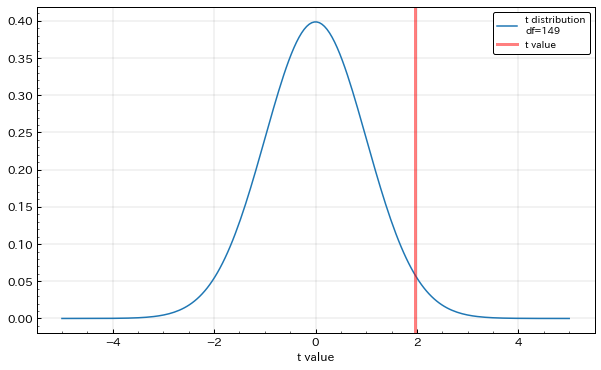

In [36]:
# t分布サンプリング
t_range = np.linspace(-5,5,200)
t_value_ar = []
for i in t_range:
    t_value_ar.append(stats.t.pdf(x=i, df=len(values1)+len(values2)-2))

# plot
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(t_range, t_value_ar, label="t distribution\ndf={}".format(len(values1)-1))
# t value
ax.axvline(x=t_value, ymin=0, ymax=1, color="red", lw=3, linestyle="-", alpha=0.5, label="t value")
ax.set_xlabel("t value")
ax.legend()

<u>母分散が等しいかの前提によって、t値の値が変化する。<br>
<u>それにより、統計的な判定の結果が変わる。

### (7) 効果量を計算する。
- 検定の結果が優位であれば、効果量を計算し意義を評価する。<br>

結果は優位でないが、ほぼ5%と同値であり、効果量を計算する。<br>

方法) Cohenのdで計算する。

Cohenのd : 2つのグループ間の平均値の差を、両グループの標準偏差のプール値で割った値。

$\text{Cohenのd} = \frac{M1 - M2}{SD_{pooled}}$

ここで
$SD_{pooled} = \sqrt{\frac{(n1 - 1) \times SD1^2 + (n2 - 1) \times SD2^2}{n1 + n2 - 2}}$

各変数は<br>
$n1$: グループ1のサンプル数<br>
$n2$: グループ2のサンプル数<br>
$SD1$: グループ1の標準偏差<br>
$SD2$: グループ2の標準偏差<br>

Cohenのdの値が大きいほど、効果量が大きいと判断する。<br>
効果量の大きさの目安は、

0.2: 小さい効果<br>
0.5: 中くらいの効果<br>
0.8: 大きい効果<br>

In [37]:
# Cohenのdの計算関数
def cohen_d(values1, values2):
    n1 = len(values1)
    n2 = len(values2)
    mean1 = np.mean(values1)
    mean2 = np.mean(values2)
    sd1 = np.std(values1, ddof=1)
    sd2 = np.std(values2, ddof=1)

    pooled_sd = np.sqrt(((n1 - 1) * sd1**2 + (n2 - 1) * sd2**2) / (n1 + n2 - 2))
    cohen_d = (mean1 - mean2) / pooled_sd

    return cohen_d

In [39]:
cohend = cohen_d(values1, values2)

print(f"Cohen d values : {cohend}")

Cohen d values : 0.2035215892659844


### 判定
Cohenのdは0.204と小さい。<br>
-> よって小さい効果。